Author: Adam Moss

Data from

https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
import datetime
import time
import matplotlib.dates as mdates
import os
import sys

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,path)

In [4]:
from covid.utils import get_ons_deaths, get_region_data, get_covid_activity

In [5]:
def gaussian_smooth(data, days=0):
    if days > 0:
        return gaussian_filter1d(data, days)
    else:
        return data

In [6]:
population = pd.read_csv('../data/all_cause_mortality/population.csv')

In [7]:
population

,year,population
0,2020,68065223
1,2019,67530172
2,2018,67141684
3,2017,66727461
4,2016,66297944
5,2015,65860146
6,2014,65423047
7,2013,64984018
8,2012,64525312
9,2011,64021919


In [8]:
df = get_ons_deaths(2020)

In [9]:
df

,week,date,areaName,totalDeaths
0,1,2020-01-03,Total,12254.0
1,2,2020-01-10,Total,14058.0
2,3,2020-01-17,Total,12990.0
3,4,2020-01-24,Total,11856.0
4,5,2020-01-31,Total,11612.0
...,...,...,...,...
578,49,2020-12-04,Wales,836.0
579,50,2020-12-11,Wales,814.0
580,51,2020-12-18,Wales,882.0
581,52,2020-12-25,Wales,NaN


In [10]:
dfs = []
for year in range(2012, 2021):
    df = get_ons_deaths(year)
    df['year'] = year
    df['totalDeathsCorrected'] = df['totalDeaths'] * population[population['year'] == 2020]['population'].values[0] / population[population['year'] == year]['population'].values[0]
    dfs.append(df)
df = pd.concat(dfs)

In [11]:
df

,week,date,areaName,totalDeaths,year,totalDeathsCorrected
0,1,2012-01-06,Total,10514.0,2012,11090.806576
1,2,2012-01-13,Total,11343.0,2012,11965.286189
2,3,2012-01-20,Total,10393.0,2012,10963.168417
3,4,2012-01-27,Total,10320.0,2012,10886.163578
4,5,2012-02-03,Total,10117.0,2012,10672.026833
...,...,...,...,...,...,...
578,49,2020-12-04,Wales,836.0,2020,836.000000
579,50,2020-12-11,Wales,814.0,2020,814.000000
580,51,2020-12-18,Wales,882.0,2020,882.000000
581,52,2020-12-25,Wales,NaN,2020,NaN


In [12]:
def week_to_date(week, year):
    return df[(df['year'] == year) & (df['week'] == week)].iloc[0]['date']

In [13]:
metrics = [
    "newCasesByPublishDate",
    "newCasesBySpecimenDate",
    "uniquePeopleTestedBySpecimenDateRollingSum",
    "uniqueCasePositivityBySpecimenDateRollingSum",
    "newDeathsByDeathDate",
    "newDeaths28DaysByPublishDate",
    "newDeaths28DaysByDeathDate",
    "newOnsDeathsByRegistrationDate",
    "newDeaths60DaysByPublishDate",
    "newDeaths60DaysByDeathDate",
]

In [14]:
nhs_metrics = [
    "newAdmissions",
    "covidOccupiedMVBeds",
    "hospitalCases"
]

In [15]:
dashboard = get_region_data(metrics=metrics, nhs_metrics=nhs_metrics)

In [16]:
covid_activity = get_covid_activity()

In [17]:
def get_excess_deaths(min_week, max_week, region):
    df_region = df[(df['year'] >= 2010) & (df['year'] <= 2019) & (df['areaName'].str.contains(region)) & (df['week'] >= min_week) & (df['week'] <= max_week)]
    agg = df_region.groupby('year').agg({'totalDeathsCorrected': [np.sum]})
    mean_deaths = np.mean(agg['totalDeathsCorrected']['sum'])
    std_deaths = np.std(agg['totalDeathsCorrected']['sum'])
    df_region = df[(df['year'] == 2020) & (df['areaName'].str.contains(region)) & (df['week'] >= min_week) & (df['week'] <= max_week)]
    agg = df_region.agg({'totalDeathsCorrected': [np.sum]})
    current_deaths = np.mean(agg['totalDeathsCorrected']['sum'])
    excess_deaths = current_deaths - mean_deaths 
    z_score = excess_deaths / std_deaths
    p_value = norm.sf(abs(z_score))*2
    return int(excess_deaths), z_score, p_value

In [23]:
def make_plot(region):
    df_region = df[(df['year'] <= 2019) & (df['areaName'].str.contains(region))].groupby(['date', 'week', 'year']).sum().reset_index()
    agg = df_region.groupby(['week']).agg({'totalDeathsCorrected': [np.mean, np.std]}).reset_index()
    plt.figure(figsize=(12,8))
    df_region = df[(df['year'] == 2020) & (df['areaName'].str.contains(region))].groupby(['date', 'week', 'year']).sum().reset_index()
    plt.plot(df_region['date'], df_region['totalDeaths'], color='red', linewidth=2, label='2020')
    plt.fill_between(df_region['date'], agg['totalDeathsCorrected']['mean'] - 2*agg['totalDeathsCorrected']['std'], 
                     agg['totalDeathsCorrected']['mean'] + 2*agg['totalDeathsCorrected']['std'], color='#8CD3F5', label='2010-2019 (2 SD)')
    plt.fill_between(df_region['date'], agg['totalDeathsCorrected']['mean'] - agg['totalDeathsCorrected']['std'], 
                     agg['totalDeathsCorrected']['mean'] + agg['totalDeathsCorrected']['std'], color='#006FED', label='2010-2019 (1 SD)')
    max_deaths = np.max(df_region['totalDeaths'])
    df_region = covid_activity[(covid_activity['areaName'].str.contains(region))].groupby(['date']).sum().reset_index()
    plt.plot(df_region['date'], gaussian_smooth(df_region['covidOccupiedMVBeds'], 0), color='green', linewidth=2, label='COVID occupied MV')
    df_region = dashboard[(dashboard['areaName'].str.contains(region))].groupby(['date']).sum().reset_index()
    plt.plot(df_region['date'], gaussian_smooth(df_region['covidOccupiedMVBeds'], 0), color='green', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Deaths')
    plt.title('Population adjusted UK weekly deaths (' + region + ')')
    plt.axvline(datetime.datetime(2020, 3, 23), label='Lockdown', color='orange', linewidth=3)
    plt.axvline(datetime.datetime(2020, 11, 5), color='orange', linewidth=3)
    plt.axvline(datetime.datetime(2021, 1, 5), color='orange', linewidth=3)
    excess_deaths, z_score, p_value = get_excess_deaths(10, 25, region)
    plt.text(week_to_date(14, 2020), max_deaths * 1.4, 'Excess deaths: %s' % excess_deaths, rotation=0)
    plt.text(week_to_date(14, 2020), max_deaths * 1.3, 'Z score: %.3e' % z_score, rotation=0)
    plt.text(week_to_date(14, 2020), max_deaths * 1.2, 'P value: %.3e' % p_value, rotation=0)
    excess_deaths, z_score, p_value = get_excess_deaths(25, 40, region)
    plt.text(week_to_date(28, 2020), max_deaths * 1.4, 'Excess deaths: %s' % excess_deaths, rotation=0)
    plt.text(week_to_date(28, 2020), max_deaths * 1.3, 'Z score: %.3e' % z_score, rotation=0)
    plt.text(week_to_date(28, 2020), max_deaths * 1.2, 'P value: %.3e' % p_value, rotation=0)
    excess_deaths, z_score, p_value = get_excess_deaths(40, 51, region)
    plt.text(week_to_date(43, 2020), max_deaths * 1.4, 'Excess deaths: %s' % excess_deaths, rotation=0)
    plt.text(week_to_date(43, 2020), max_deaths * 1.3, 'Z score: %.3e' % z_score, rotation=0)
    plt.text(week_to_date(43, 2020), max_deaths * 1.2, 'P value: %.3e' % p_value, rotation=0)
    plt.axvline(week_to_date(10, 2020), linestyle='--')
    plt.axvline(week_to_date(26, 2020), linestyle='--')
    plt.axvline(week_to_date(41, 2020), linestyle='--')
    plt.axvline(week_to_date(52, 2020), linestyle='--')
    ax = plt.gca()
    ax.set_ylim([0, max_deaths * 1.5])
    ax.set_xlim([datetime.datetime(2020, 1, 1), datetime.datetime.now()])
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    plt.legend(loc='upper left')
    plt.gcf().autofmt_xdate() # Rotation
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.savefig('plots/all_cause_mortality/' + region.replace(' ','') + '.png', transparent=False, facecolor='white')

In [24]:
regions = df['areaName'].unique().tolist() + ['North', 'Midlands', 'South']

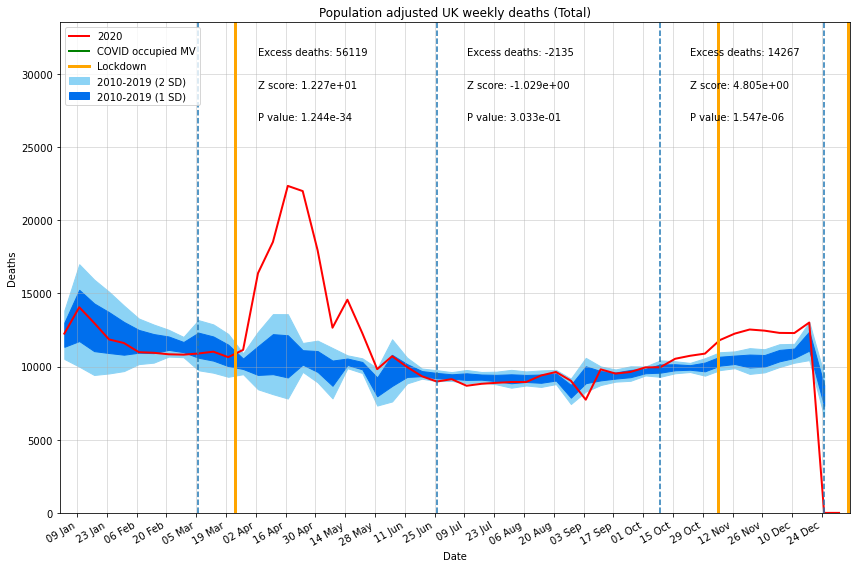

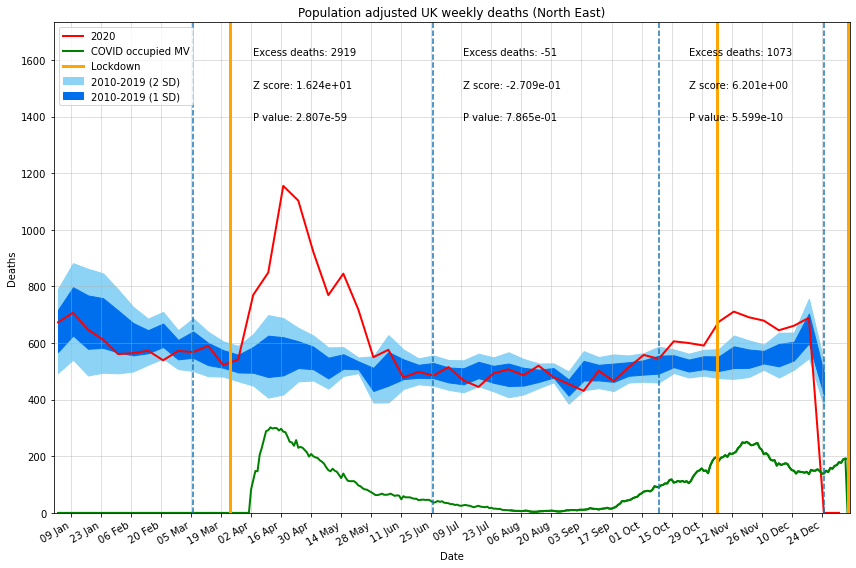

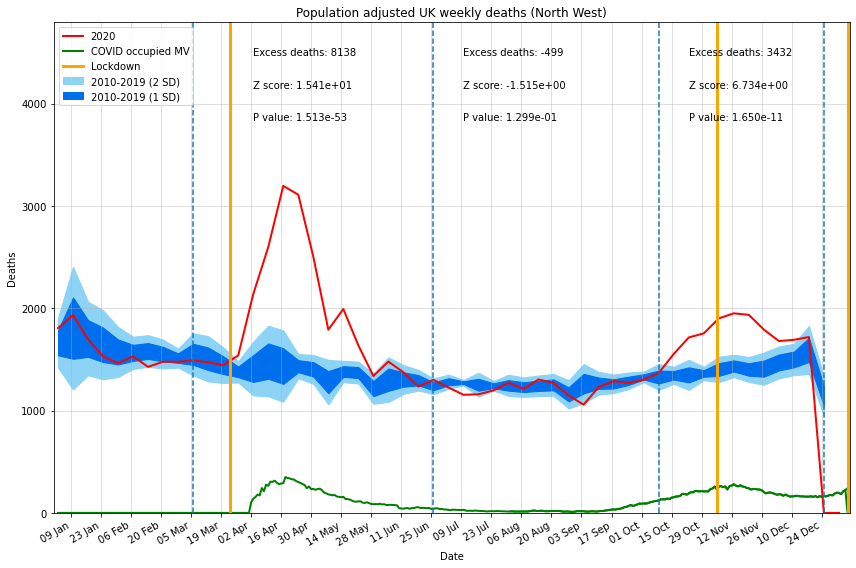

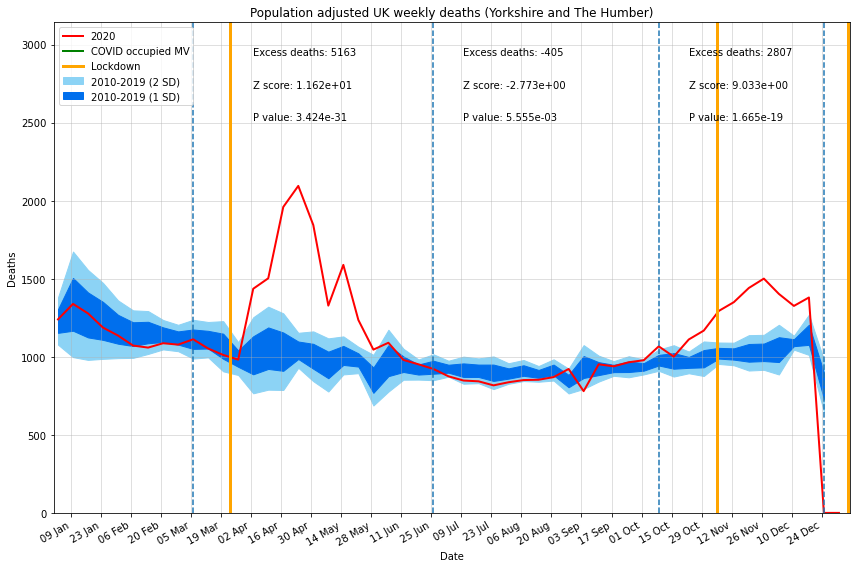

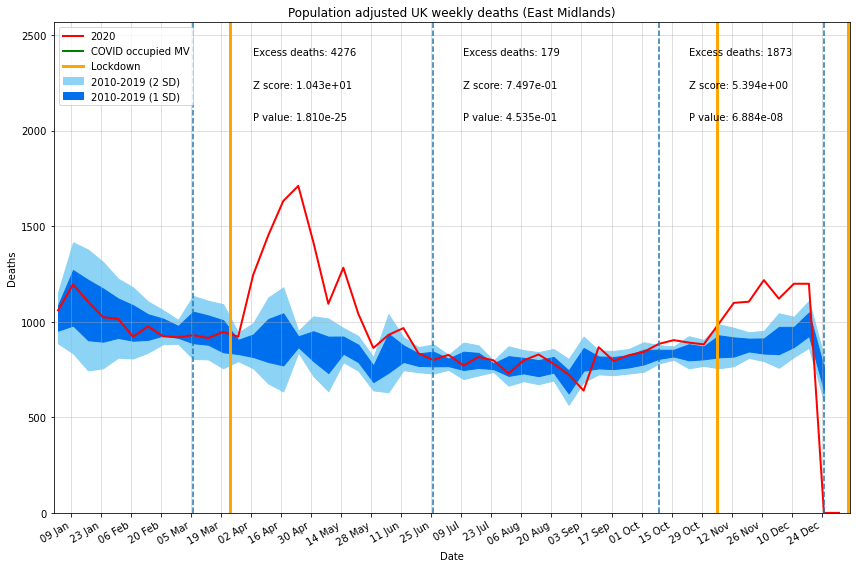

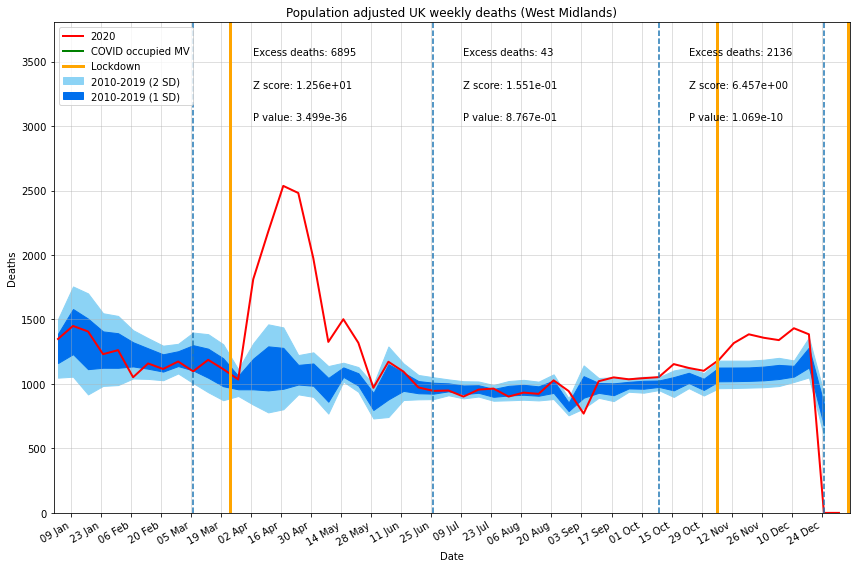

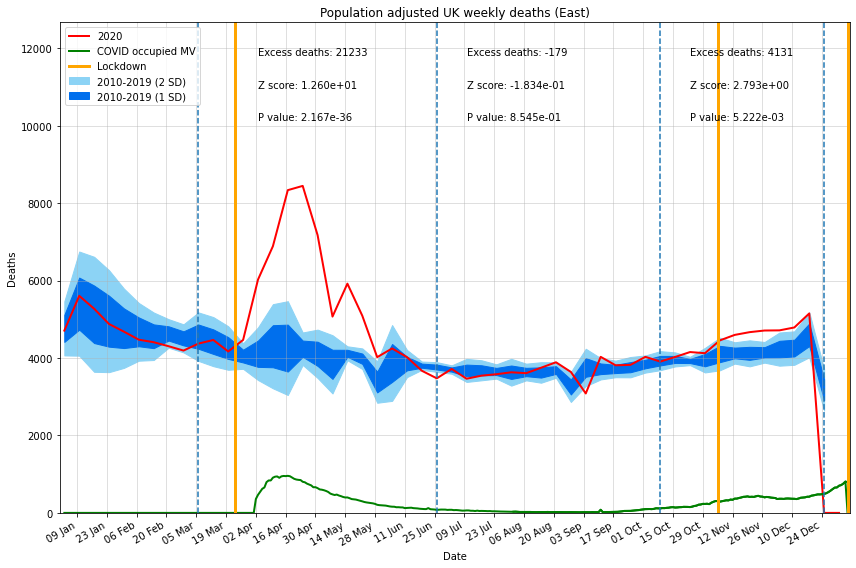

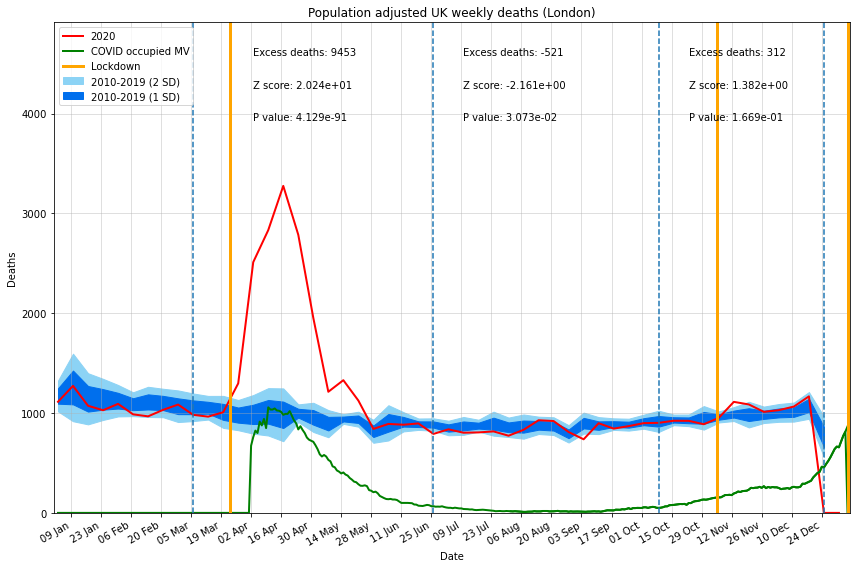

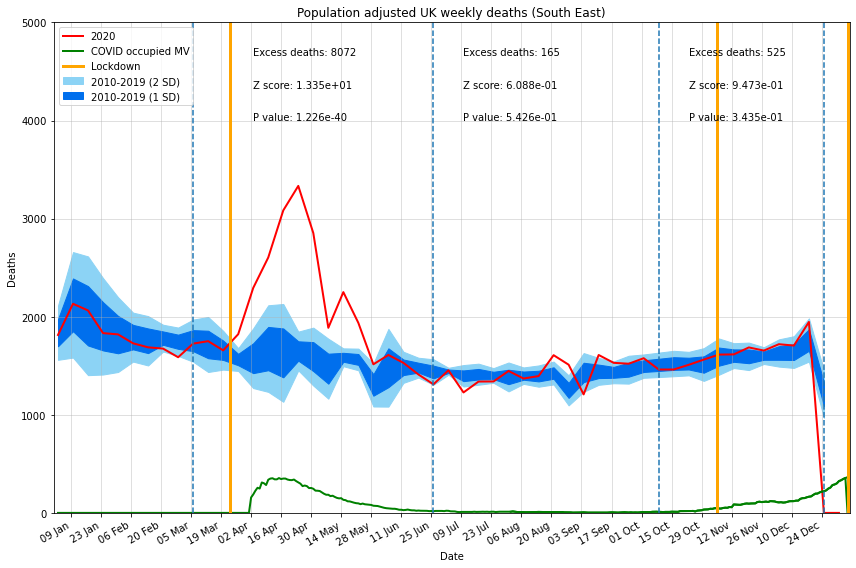

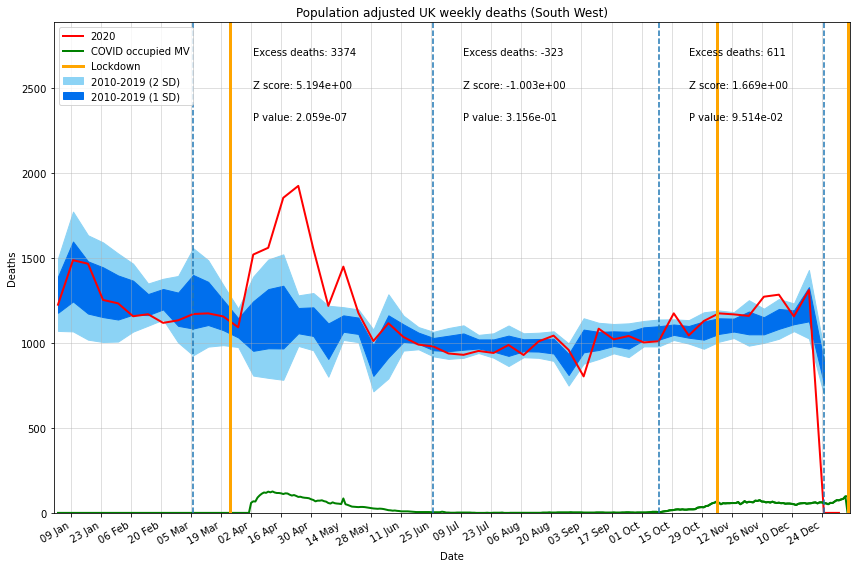

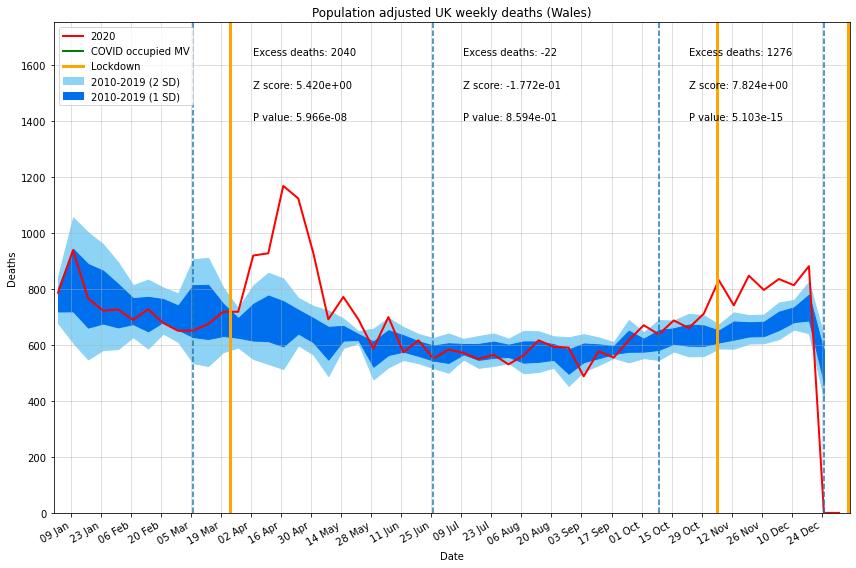

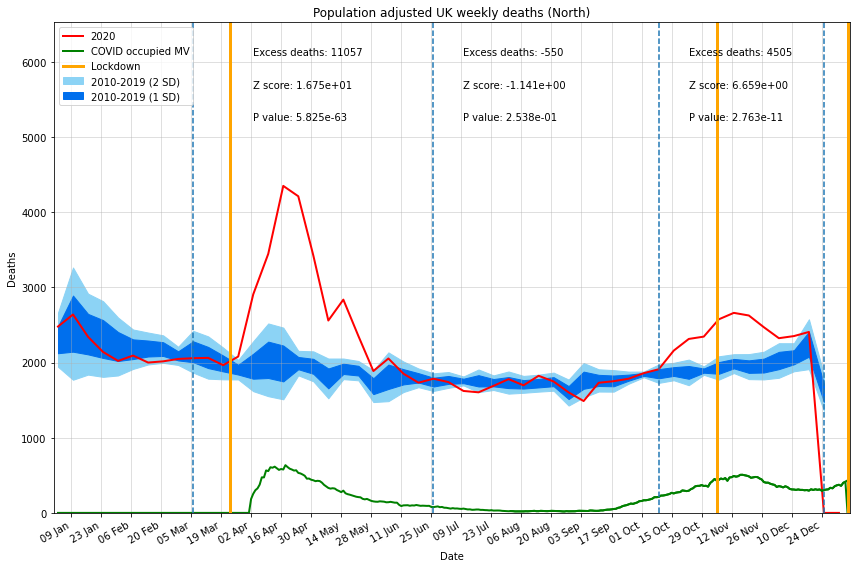

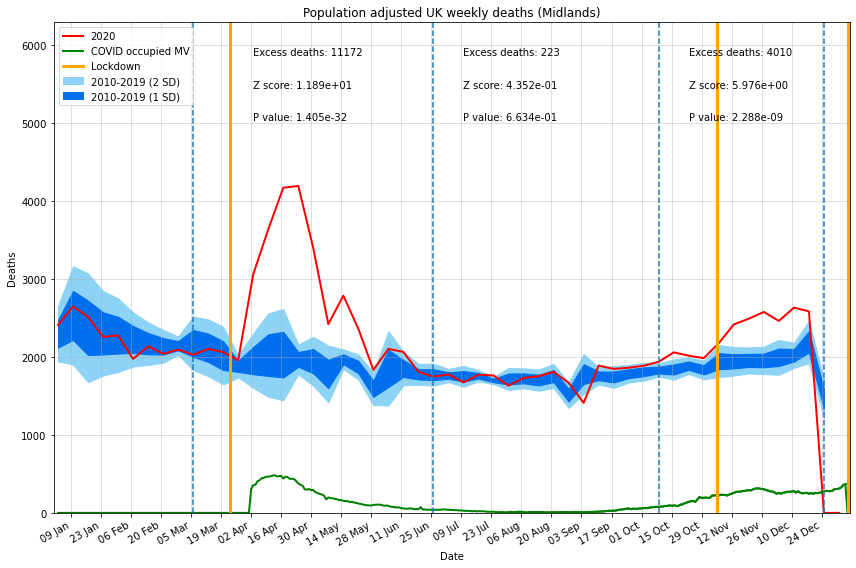

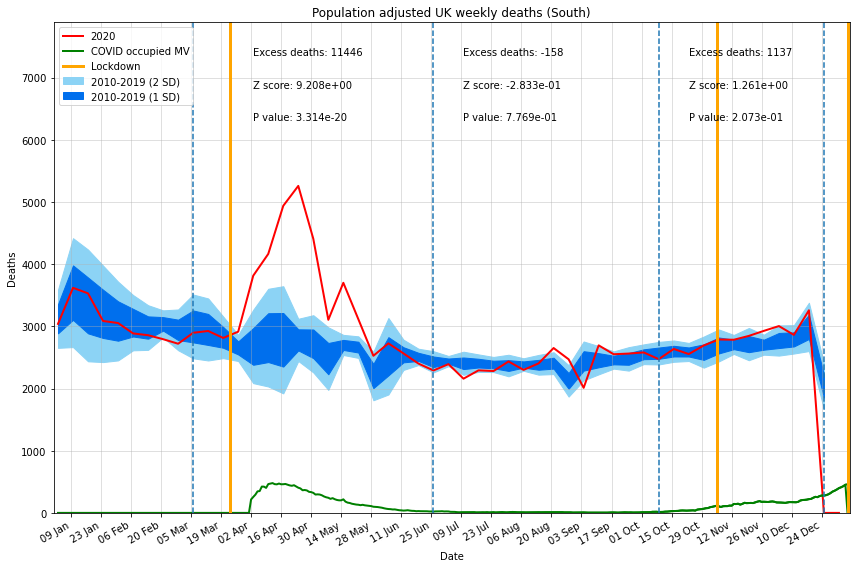

In [25]:
for region in regions:
    make_plot(region)